In [1]:
from IPython.display import HTML, display
css_file_path = "../../design/custom.css"
styles = "<link rel='stylesheet' href='%s'>" % css_file_path
display(HTML(styles))

# Ejercicio 1: Optimización de carteras de Markowitz

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import yfinance as yf
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
from scipy.interpolate import interp1d

plt.style.use('ggplot')

## Datos simulados

### Ejercicio 1: Cálculo de la cartera con Mínimo Riesgo

**Objetivo**: Minimizar el riesgo de una cartera.

#### Datos:
- **Retornos Esperados**: Un array `retornos_esperados` que contiene el retorno esperado para cada activo.
- **Matriz de Covarianza**: `matriz_cov`, describiendo la covarianza entre los activos y el riesgo combinado.

#### Restricciones:
1. No se permiten posiciones cortas.

Recordad que la varianza de una cartera, $ \sigma^2_p $, se calcula como:

$ \qquad \qquad \sigma^2_p = w^T \Sigma w $

donde:
- $ w $ es el vector de pesos de la cartera. Cada elemento $ w_i $ representa la fracción del capital total invertido en el activo $ i $.
- $ \Sigma $ es la matriz de covarianza de los rendimientos de los activos. Cada elemento $ \sigma_{ij} $ representa la covarianza entre los rendimientos de los activos $ i $ y $ j $.

In [4]:
# Datos de retornos y covarianzas

retornos_esperados = np.array([0.17, 0.10, 0.07, 0.09])  # Ejemplo de retornos esperados

matriz_cov = np.array([[1.83977374, 1.23002575, 1.59282297, 0.69409837],
                       [1.23002575, 1.45345954, 1.7548078 , 1.31477996],
                       [1.59282297, 1.7548078 , 2.14425197, 1.55568552],
                       [0.69409837, 1.31477996, 1.55568552, 1.46502412]])

In [5]:
# Variable de decisión. La cartera tiene 4 pesos ya que hay 4 activos
pesos = cp.Variable(4)

En `cvxpy`, `cp.quad_form(x, P)` toma dos argumentos:

- `x`: Una variable o vector de variables en el problema de optimización.
- `P`: Una matriz que define cómo las variables en `x` se combinan y se cuadran.

La forma cuadrática resultante se calcula como $x^T P x$, donde $x^T$ es la transpuesta del vector `x` y `P` es la matriz dada.


In [6]:
# Función objetivo
riesgo = cp.quad_form(pesos, matriz_cov)
objetivo = cp.Minimize(riesgo)

In [7]:
# Restricciones
constraints = [cp.sum(pesos) == 1, 
               pesos >= 0]

In [8]:
# Problema de optimización
problema = cp.Problem(objetivo, constraints)

# Resolviendo el problema
resultado = problema.solve()

# Resultados
pesos_optimos = pesos.value

In [10]:
print(f'El riesgo de la cartera es: {riesgo.value:.2f}')
print(f'La rentabilidad de la cartera es: {100*(retornos_esperados @ pesos_optimos).round(4)}%')
print(f'Los pesos que hacen que la cartera tenga el menor riesgo son: {100*pesos_optimos.round(2)}')

El riesgo de la cartera es: 1.15
La rentabilidad de la cartera es: 12.22%
Los pesos que hacen que la cartera tenga el menor riesgo son: [40. -0. -0. 60.]


### Apartados adicionales
- Resolver el problema anterior si además quieres una rentabilidad mínima del 14%

In [14]:
# Restricciones
constraints = [cp.sum(pesos) == 1, 
               pesos >= 0,
               retornos_esperados @ pesos >= 0.14]

In [15]:
# Problema de optimización
problema = cp.Problem(objetivo, constraints)

# Resolviendo el problema
resultado = problema.solve()

# Resultados
pesos_optimos = pesos.value

In [16]:
print(f'El riesgo de la cartera es: {riesgo.value:.2f}')
print(f'La rentabilidad de la cartera es: {(100*(retornos_esperados @ pesos_optimos)).round(2)}%')
print(f'Los pesos que hacen que la cartera tenga el menor riesgo son: {100*pesos_optimos.round(2)}')

El riesgo de la cartera es: 1.25
La rentabilidad de la cartera es: 14.0%
Los pesos que hacen que la cartera tenga el menor riesgo son: [62. -0. -0. 38.]


- ¿Y si la rentabilidad mínima es del 18%?

In [17]:
# Restricciones
constraints = [cp.sum(pesos) == 1, 
               pesos >= 0,
               retornos_esperados @ pesos >= 0.18]


# Problema de optimización
problema = cp.Problem(objetivo, constraints)

# Resolviendo el problema
resultado = problema.solve()

# Resultados
pesos_optimos = pesos.value

In [22]:
print(f'Los pesos que hacen que la cartera tenga el menor riesgo son: {100*pesos_optimos.round(2)}')

AttributeError: 'NoneType' object has no attribute 'round'

Las restricciones establecidas en este problema de optimización hacen que no tenga solución.

Dado que el rendimiento más alto de los activos es del 17%, es imposible lograr una rentabilidad del 18% con una cartera formada por estos activos.

### Ejercicio 2:  Cálculo de la cartera con Máxima Rentabilidad dado un Riesgo

**Objetivo**: Maximizar la rentabilidad de una cartera asegurando un riesgo máximo.

#### Datos (los del ejercicio anterior):
- **Retornos Esperados**: Un array `retornos_esperados` que contiene el retorno esperado para cada activo.
- **Matriz de Covarianza**: `matriz_cov`, describiendo la covarianza entre los activos y el riesgo combinado.


#### Restricciones:
1. No se permiten posiciones cortas.
2. El riesgo debe ser menor que 1.2

In [34]:
# Variable de decisión
pesos = cp.Variable(4)

In [35]:
# Función objetivo
rentabilidad = retornos_esperados @ pesos
objetivo = cp.Maximize(rentabilidad)

In [36]:
# Restricciones
riesgo = cp.quad_form(pesos, matriz_cov)

constraints = [cp.sum(pesos) == 1, 
               pesos >= 0,
               riesgo <= 1.20]

In [37]:
# Problema de optimización
problema = cp.Problem(objetivo, constraints)

# Resolviendo el problema
resultado = problema.solve(solver="ECOS")

pesos_optimos = pesos.value

In [38]:
retornos_esperados.shape

(4,)

In [39]:
pesos.shape

(4,)

In [41]:
print(f'El riesgo de la cartera es: {riesgo.value:.2f}')
print(f'La rentabilidad de la cartera es: {(100*(retornos_esperados @ pesos_optimos)).round(2)}%')
print(f'Los pesos que hacen que la cartera tenga el menor riesgo son: {100*pesos_optimos.round(2)}')

El riesgo de la cartera es: 1.20
La rentabilidad de la cartera es: 13.44%
Los pesos que hacen que la cartera tenga el menor riesgo son: [56.  0.  0. 44.]


## Datos reales

In [42]:
# Date range
start = '2015-01-01'
end = '2019-12-30'

# Assets todos con retornos positivos
assets_positivos = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'HPQ', 'JCI', 'JPM',
        'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 'T', 'TGT', 'TMO',
        'TXT', 'VZ', 'ZION']

assets_muy_negativos = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'F', 'GE', 'HPQ', 
        'JCI', 'JPM','KHC', 'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 
        'T', 'TGT', 'TMO','TXT', 'VZ', 'ZION']

assets_un_negativo = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'F', 'HPQ', 
        'JCI', 'JPM', 'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 
        'T', 'TGT', 'TMO','TXT', 'VZ', 'ZION']

assets = assets_muy_negativos



# Downloading data
prices = yf.download(assets, start = start, end = end)['Adj Close']
prices.columns = assets

[*********************100%%**********************]  26 of 26 completed


In [43]:
#Número de activos
num_act = prices.shape[1]

In [46]:
#Calculamos los retornos logaritmicos
returns = np.log(prices).diff().dropna()
returns.head(2)

,BA,BAX,BMY,CMCSA,CNP,CPB,DE,F,GE,HPQ,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-07,0.018543,-0.024752,0.010757,0.006420,0.019578,0.014909,0.007402,0.004048,0.006063,0.007495,...,0.016490,0.003578,0.022570,0.003248,0.004483,0.018163,0.004286,-0.003387,0.004454,-0.021060
2015-07-08,-0.008629,-0.016574,-0.007208,-0.013205,-0.019578,-0.008582,-0.013805,-0.032857,-0.022155,-0.011429,...,0.001167,-0.023246,0.003109,-0.023935,-0.010230,-0.011552,-0.021224,-0.028682,-0.002573,-0.026209


In [47]:
#Calculamos la matriz de covarianzas y los retornos esperados
matriz_cov = returns.cov().to_numpy()
retornos_esperados = returns.mean().to_numpy()

Vemos las correlaciones entre los activos

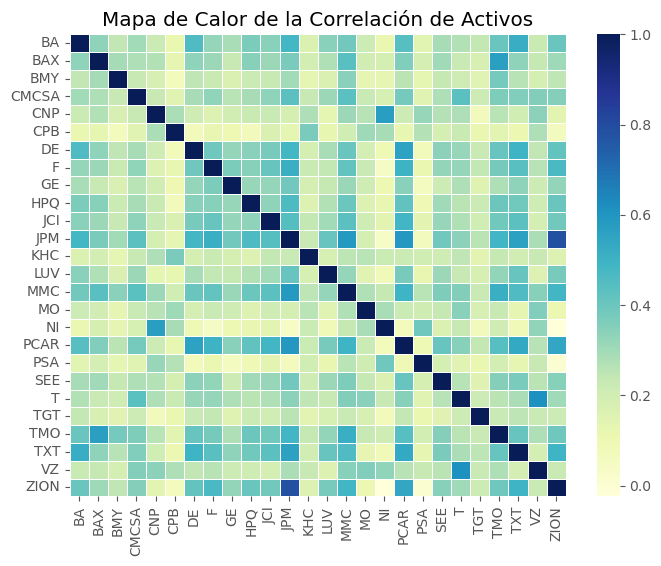

In [48]:
# Correlation matrix
mat_corr = returns.corr().to_numpy() 

# Configurando el tamaño de la figura
plt.figure(figsize=(8, 6))
sns.heatmap(mat_corr, linewidths=.5, cmap="YlGnBu", xticklabels=assets, yticklabels=assets)
# Añadiendo título
plt.title("Mapa de Calor de la Correlación de Activos")

# Mostrando la gráfica
plt.show()

Hacemos la gráfica de rentabilidad-riesgo de los activos

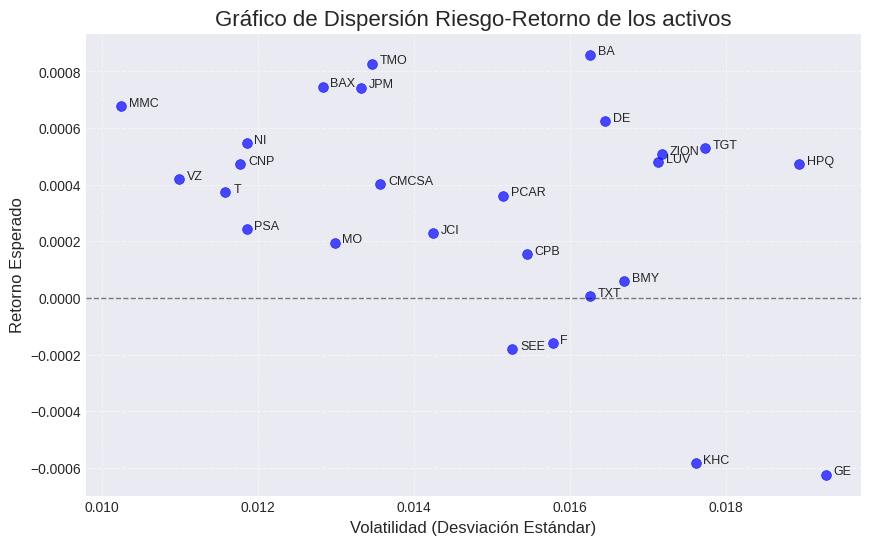

In [49]:
# Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, label='Activos', alpha=0.7)

plt.axhline(0, color='black', lw=1, linestyle='--', alpha=0.5)

# Añadiendo títulos y etiquetas
plt.title('Gráfico de Dispersión Riesgo-Retorno de los activos', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)



# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()


## Ejercicio 3: Cálculo de la cartera de *mínimo riesgo*

Calcula la cartera de *mínimo riesgo* sin posiciones cortas.

In [110]:
#Variables de decisión
pesos = cp.Variable(num_act)

In [111]:
#Restricciones
constraints = [pesos >= 0,
               cp.sum(pesos) == 1,
               ]

In [112]:
#Función Objetivo

riesgo = cp.quad_form(pesos, matriz_cov) # Riesgo de la cartera
objective = cp.Minimize(riesgo) # Minimizar la varianza

In [113]:
#Problema y resuelvo
prob = cp.Problem(objective, constraints)
resultado = prob.solve()

In [114]:
#Guardamos los valores de la rentabilidad y riesgo de la cartera de mínimo riesgo
ret = retornos_esperados.T @ pesos 
min_riesgo = np.array([riesgo.value, ret.value])

In [115]:
print(f'Los pesos que hacen que la cartera tenga el mínimo riesgo son: \n{pesos.value}')

Los pesos que hacen que la cartera tenga el mínimo riesgo son: 
[-1.52268384e-19  7.18322818e-02  3.84886114e-02  1.82475378e-02
  6.19052749e-02  3.86457915e-02  2.26851325e-04  5.16957672e-03
  3.81679919e-03 -4.85686732e-19  3.56269991e-02  3.94723119e-02
  2.70015662e-19  2.92424101e-02  1.03709910e-01  7.00228230e-02
  1.06629414e-01 -1.09172642e-19  1.56190622e-01  4.59049472e-03
  8.12776484e-02  4.68246180e-02 -3.26448623e-19 -4.18252863e-19
  8.66575425e-02  1.42248167e-03]


Podemos visualizar los pesos de diferentes formas. Una de ellas es dibujar en un diagrama de barras el peso $w_i$ de cada activo.

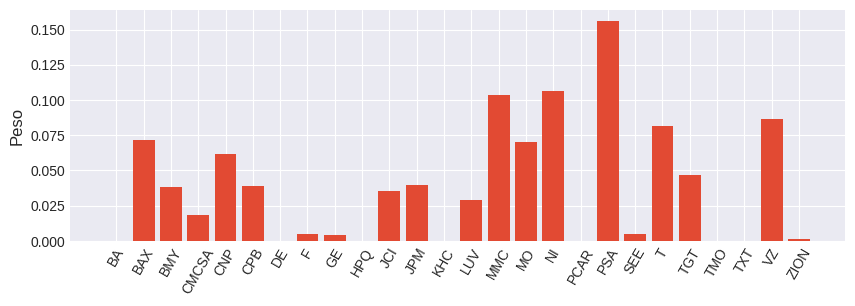

In [116]:
plt.figure(figsize=(10, 3))
plt.bar(range(num_act), pesos.value)
plt.xticks(range(num_act), assets, rotation=60)
plt.ylabel("Peso")
plt.show()

Otra opción es dibujar un gráfico circular (diagrama de sectores).

In [117]:
pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value])
pesos_ajustados

array([0.   , 0.072, 0.038, 0.018, 0.062, 0.039, 0.   , 0.005, 0.004,
       0.   , 0.036, 0.039, 0.   , 0.029, 0.104, 0.07 , 0.107, 0.   ,
       0.156, 0.005, 0.081, 0.047, 0.   , 0.   , 0.087, 0.001])

In [118]:
activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x > 0]

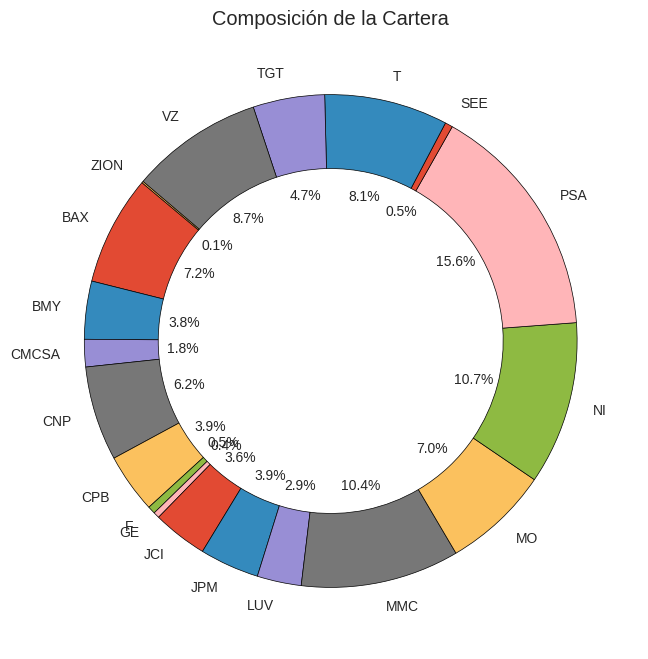

In [119]:
# Crear el gráfico de donut
plt.figure(figsize=(8, 8))

plt.pie(pesos_filtrados, labels=activos_filtrados, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.3, 'edgecolor': 'black'})

# Añadir título
plt.title('Composición de la Cartera')

# Mostrar el gráfico
plt.show()

## Ejercicio 4: Cálculo de la cartera de *máxima rentabilidad*

Ahora se trata de calcular la cartera de mayor rentabilidad teniendo en cuenta que no se permiten posiciones cortas.

In [122]:
#Variables de decisión
pesos = cp.Variable(num_act)

In [123]:
#Restricciones
constraints = [pesos >= 0,  # No shorting
               cp.sum(pesos) == 1, # Fully invested
               ]

In [124]:
# Cálculo de la cartera de máxima rentabilidad

ret = retornos_esperados.T @ pesos 

objective = cp.Maximize(ret)

prob = cp.Problem(objective, constraints)
resultado = prob.solve(solver=cp.ECOS)

In [125]:
#Guardamos los valores de la rentabilidad y riesgo de la cartera de máxima rentabilidad
riesgo = cp.quad_form(pesos, matriz_cov)
max_ret = np.array([riesgo.value, ret.value])

Visualicemos de nuevo los pesos, tanto con un diagrama de barras como con un gráfico circular.

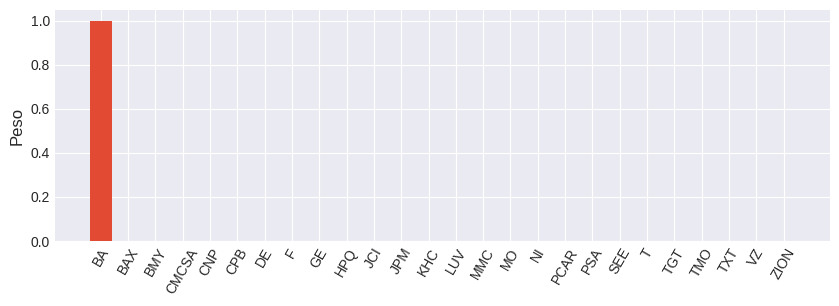

In [126]:
plt.figure(figsize=(10, 3))
plt.bar(range(num_act), pesos.value)
plt.xticks(range(num_act), assets, rotation=60)
plt.ylabel("Peso")
plt.show()

In [127]:
pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value])

activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x > 0]

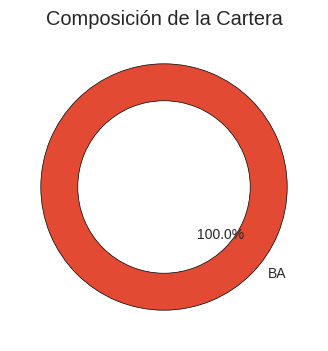

In [128]:
# Crear el gráfico de donut
plt.figure(figsize=(4, 4))

plt.pie(pesos_filtrados, labels=activos_filtrados, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.3, 'edgecolor': 'black'})

# Añadir título
plt.title('Composición de la Cartera')

# Mostrar el gráfico
plt.show()

Ahora vamos a representar estas carteras junto con los activos.

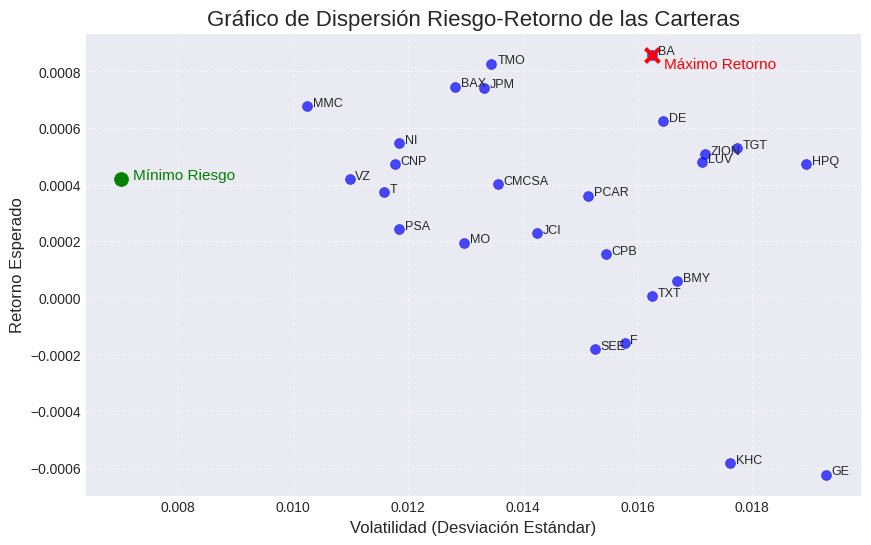

In [129]:
# Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, label='Activos', alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00005  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)


# Punto de mínimo riesgo
plt.scatter(np.sqrt(min_riesgo[0]), min_riesgo[1], color='green', s=100, marker='o', label='Mínimo Riesgo')
plt.text(np.sqrt(min_riesgo[0]) + 2*desplazamiento_x, min_riesgo[1], 'Mínimo Riesgo', fontsize=11, color='green')

# Punto de máximo retorno
plt.scatter(np.sqrt(max_ret[0]), max_ret[1], color='red', s=100, marker='x', linewidths=3, label='Máximo Retorno')
plt.text(np.sqrt(max_ret[0]) + 2*desplazamiento_x, max_ret[1] - desplazamiento_y, 'Máximo Retorno', fontsize=11, color='red')

# Añadiendo títulos y etiquetas
plt.title('Gráfico de Dispersión Riesgo-Retorno de las Carteras', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()


## Ejercicio 5: Cartera de *máxima rentabilidad* dado un *riesgo máximo permitido*

Se trata de encontrar la cartera que, no excediendo el riesgo máximo definido de `0.012`, genere la máxima rentabilidad.

In [130]:
#riesgo máximo
riesgo_obj = 0.012

In [131]:
#Variables de decisión
pesos = cp.Variable(num_act)

# Función objetivo
rentabilidad = cp.Maximize(retornos_esperados.T @ pesos)

#Restricciones
riesgo = cp.quad_form(pesos, matriz_cov)

constraints = [pesos >= 0,
                cp.sum(pesos) == 1,
                riesgo <= riesgo_obj**2 # OJO AQUI! riesgo objetivo al cuadrado
                ]

prob = cp.Problem(rentabilidad, constraints)
resultado = prob.solve(solver=cp.ECOS)

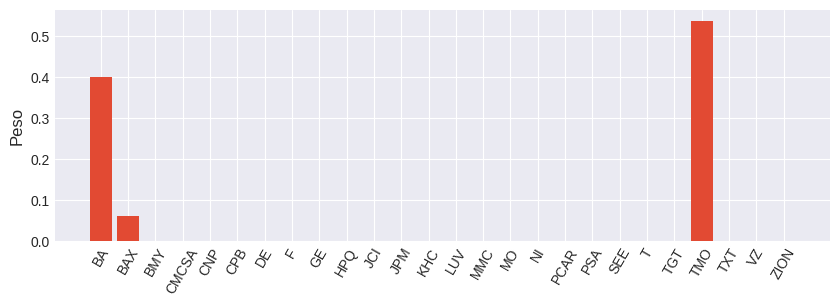

In [134]:
plt.figure(figsize=(10, 3))
plt.bar(range(num_act), pesos.value)
plt.xticks(range(num_act), assets, rotation=60)
plt.ylabel("Peso")
plt.show()

In [132]:
pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value])

activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x > 0]

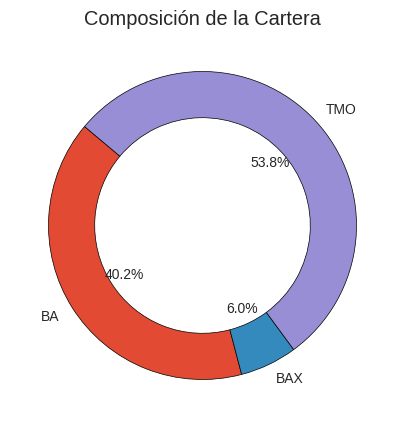

In [133]:
# Crear el gráfico de donut
plt.figure(figsize=(5, 5))

plt.pie(pesos_filtrados, labels=activos_filtrados, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.3, 'edgecolor': 'black'})

# Añadir título
plt.title('Composición de la Cartera')

# Mostrar el gráfico
plt.show()

Veamos la cartera junto a los distintos activos.

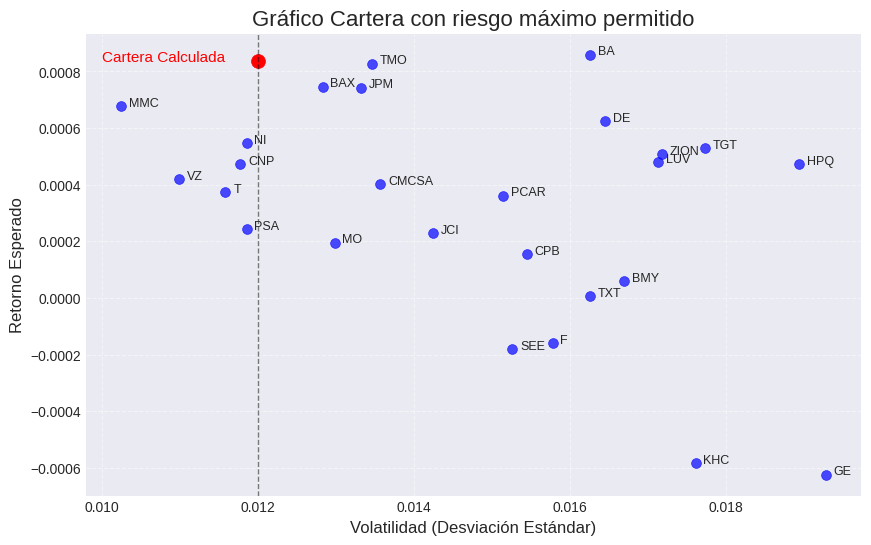

In [135]:
#Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)


# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)



plt.scatter(np.sqrt(riesgo.value), resultado, color='red', s=100, marker='o')
plt.text(np.sqrt(riesgo.value) - 20 * desplazamiento_x, resultado, 'Cartera Calculada', fontsize=11, color='red')

plt.axvline(riesgo_obj, color='black', lw=1, linestyle='--', alpha=0.5)


# Añadiendo títulos y etiquetas
plt.title('Gráfico Cartera con riesgo máximo permitido', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

## Ejercicio 6: Cáculo de la cartera de *máxima rentabilidad según tolerancia al riesgo*

Los inversores tienen distintos niveles de tolerancia al riesgo, conocida como aversión al riesgo. Recordad la ecuación definida por Markowitz:

$$\underset{w}{\max} f(w)=w^T\mu-\lambda w^T\Sigma w$$

Ahora vamos a calcular las carteraas con la mayor rentabilidad para distintos niveles de aversión al riesgo.

- El factor $\Large \boldsymbol{\lambda}$ representa la aversión al riesgo de un inversor.

- Hay que tener en cuenta que $\Large \boldsymbol{\lambda}$ $\geq 0$ 
  
- Un $\Large \boldsymbol{\lambda}$ bajo indica mayor tolerancia al riesgo para buscar altos rendimientos.
  
- Un $\Large \boldsymbol{\lambda}$ alto muestra preferencia por inversiones seguras con rendimientos menores.
  
- $\Large \boldsymbol{\lambda}$ equilibra riesgo y rendimiento en la selección de carteras.


Nota: Este ejemplo se basa en la documentación de la librería [CVXPY Documentation](https://www.cvxpy.org/)


In [136]:
#Variables de decisión
pesos = cp.Variable(num_act)

# Factor aversión al riesgo
gamma = cp.Parameter(nonneg=True) # No lo llamo lambda porque es una palabra reservada en python

ret = retornos_esperados.T @ pesos

riesgo = cp.quad_form(pesos, matriz_cov)

Definimos la **función objetivo**:

- La función objetivo busca maximizar las ganancias, pero reduce la rentabilidad si hay mucho riesgo.

- Restar el riesgo multiplicado por el factor gamma hace que, a igual rentabilidad, se elijan carteras menos riesgosas.

- Con un gamma alto, que indica poca tolerancia al riesgo, se prioriza la seguridad aunque las ganancias sean menores.

In [137]:
objetivo = cp.Maximize(ret - gamma*riesgo)

In [138]:
#Restricciones y función objetivo
constraints = [pesos >= 0,
               cp.sum(pesos) == 1
               ]

prob = cp.Problem(objetivo, constraints)

In [139]:
#resolvemos para diferentes valores de gamma
num_sim = 100
riesgos_res = np.zeros(num_sim)
retornos_res = np.zeros(num_sim)
pesos_res = np.zeros((num_sim, num_act))
gamma_vals = np.logspace(-2, 3, num=num_sim)

for i in range(num_sim):
    gamma.value = gamma_vals[i]
    prob.solve()
    retornos_res[i] = ret.value
    riesgos_res[i] = cp.sqrt(riesgo).value
    pesos_res[i, :] = pesos.value


Vamos a interpolar los puntos calculados

In [140]:
# Crear un diccionario para mapear riesgos a retornos y quedarme con un array sin duplicados
riesgo_retorno_dict = dict(zip(riesgos_res, retornos_res))
x = np.array(list(riesgo_retorno_dict.keys()))
y = np.array(list(riesgo_retorno_dict.values()))

In [141]:
#Interpolo los puntos y obtengo la frontera eficiente

frontera_eficiente = interp1d(x, y, kind='cubic')
x_nuevos = np.linspace(min(riesgos_res), max(riesgos_res), num=500)
y_nuevos = frontera_eficiente(x_nuevos)

Ahora representamos todo

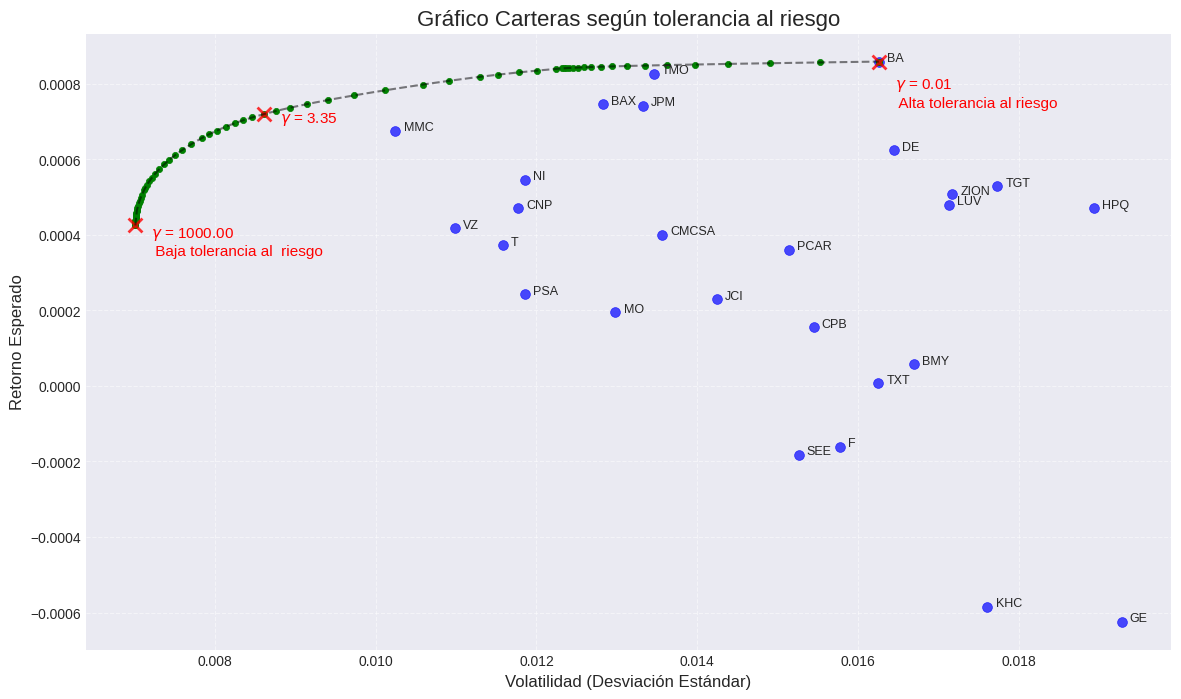

In [142]:
# Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(14, 8))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, label='Activos', alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00002  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')#,  alpha=0.3)   

plt.plot(x_nuevos, y_nuevos, '--', color='black', label='Frontera Eficiente', alpha=0.5)

plt.scatter(riesgos_res[num_sim-1], retornos_res[num_sim-1], color='red', s=100, marker='x',  linewidths=2, alpha=0.8, label = f'$\gamma$ = {gamma_vals[num_sim-1]:.2f}')
plt.text(riesgos_res[num_sim-1] + 2*desplazamiento_x, retornos_res[num_sim-1] - 4 * desplazamiento_y, f'$\gamma$ = {gamma_vals[num_sim-1]:.2f} \n Baja tolerancia al  riesgo', fontsize=11, color='red')

plt.scatter(riesgos_res[int(num_sim/2)], retornos_res[int(num_sim/2)], color='red', s=100, marker='x',  linewidths=2, alpha=0.8, label = f'$\gamma$ = {gamma_vals[int(num_sim/2)]:.2f}')
plt.text(riesgos_res[int(num_sim/2)] + 2*desplazamiento_x, retornos_res[int(num_sim/2)] - desplazamiento_y, f'$\gamma$ = {gamma_vals[int(num_sim/2)]:.2f}', fontsize=11, color='red')

plt.scatter(riesgos_res[int(0)], retornos_res[int(0)], color='red', s=100, marker='x',  linewidths=2, alpha=0.8, label = f'$\gamma$ = {gamma_vals[int(0)]:.2f}')
plt.text(riesgos_res[int(0)] + 2*desplazamiento_x, retornos_res[int(0)] - 6*desplazamiento_y, f'$\gamma$ = {gamma_vals[0]:.2f}\n Alta tolerancia al riesgo', fontsize=11, color='red')

# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras según tolerancia al riesgo', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()



/tmp/ipykernel_34900/3766192035.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  paleta = cm.get_cmap('tab20c', num_act)


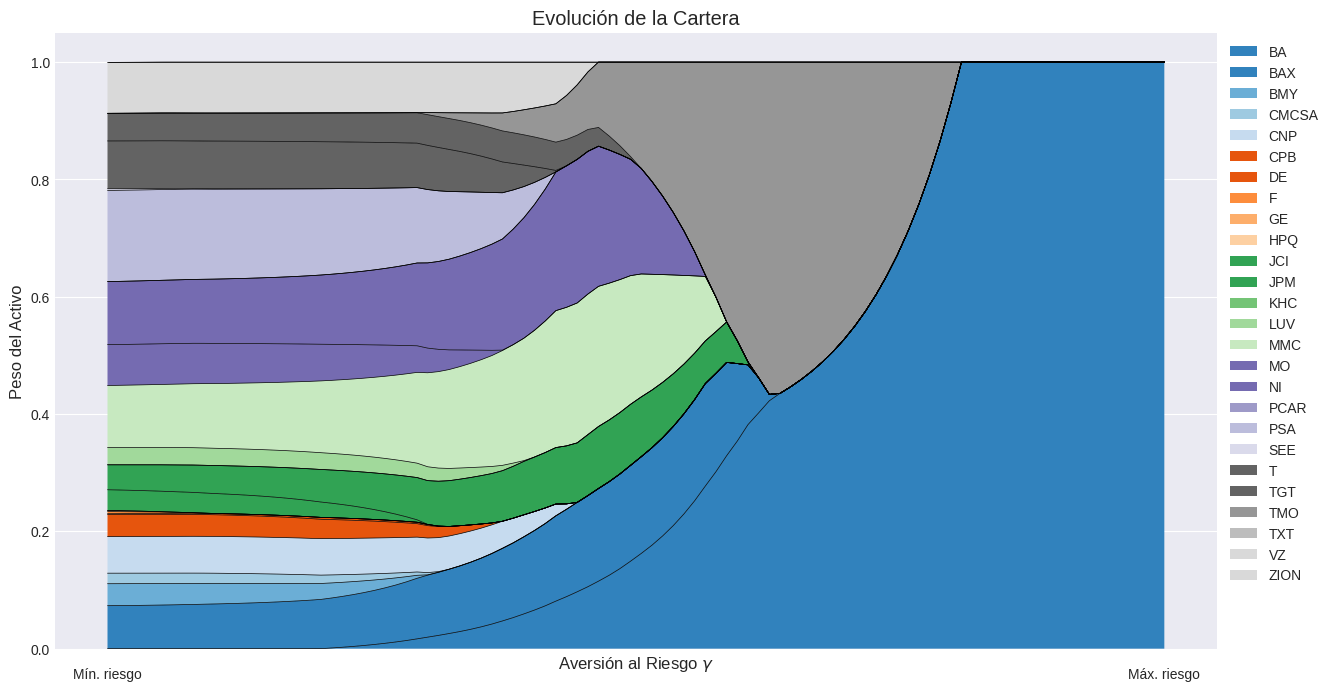

In [151]:
# Elegir una paleta de colores y generar colores
from matplotlib import cm
paleta = cm.get_cmap('tab20c', num_act)
colores = [paleta(i) for i in range(num_act)]

# Crear una gráfica de áreas apiladas
tiempo = np.arange(num_sim)  # Eje x - tiempo

plt.figure(figsize=(15, 8))

plt.stackplot(tiempo, pesos_res.T, colors=colores, labels=[f'{assets[i]}' for i in range(num_act)])

# Añadir bordes a las áreas
for i in range(num_act):
    plt.plot(tiempo, np.sum(pesos_res[:, :i+1], axis=1), color='black', linewidth=0.5)

# Invertir el eje x
plt.gca().invert_xaxis()

# Añadir texto personalizado en el eje x
plt.text(num_sim-1, -0.05, 'Mín. riesgo', ha='center')  # Cerca del 100
plt.text(0, -0.05, 'Máx. riesgo', ha='center')         # Cerca del 0


plt.xlabel('Aversión al Riesgo $\gamma$')
plt.ylabel('Peso del Activo')
plt.title('Evolución de la Cartera')

# Ajustar la leyenda fuera del área del gráfico
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks([],[])

plt.show()

## Ejercicio 7: Carteras con restricciones en la cantidad máxima invertida en un activo

Se trata de calcular la cartera con mayor rentabilidad posible pero asegurando que no se invierte más de un porcentaje en un solo activo.

In [152]:
#Variables de decisión
pesos = cp.Variable(num_act)

# Función objetivo
rentabilidad = cp.Maximize(retornos_esperados.T @ pesos)

# #Restricciones

max_inv = 0.1 # Máxima inversión en un activo

constraints = [pesos >= 0,
               cp.sum(pesos) == 1,
               pesos <= max_inv
              ]

prob = cp.Problem(rentabilidad, constraints)
resultado = prob.solve(solver=cp.ECOS)

In [153]:
pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value])

activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x > 0]

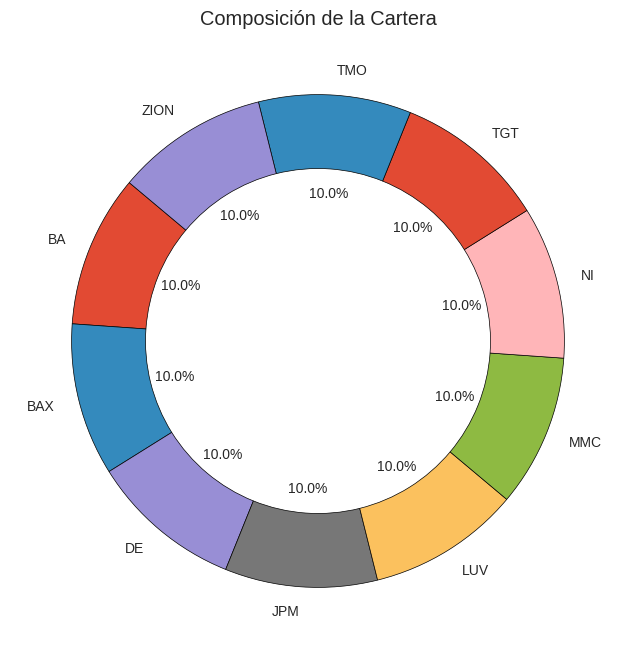

In [154]:
# Crear el gráfico de donut
plt.figure(figsize=(8, 8))

plt.pie(pesos_filtrados, labels=activos_filtrados, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.3, 'edgecolor': 'black'})

# Añadir título
plt.title('Composición de la Cartera')

# Mostrar el gráfico
plt.show()

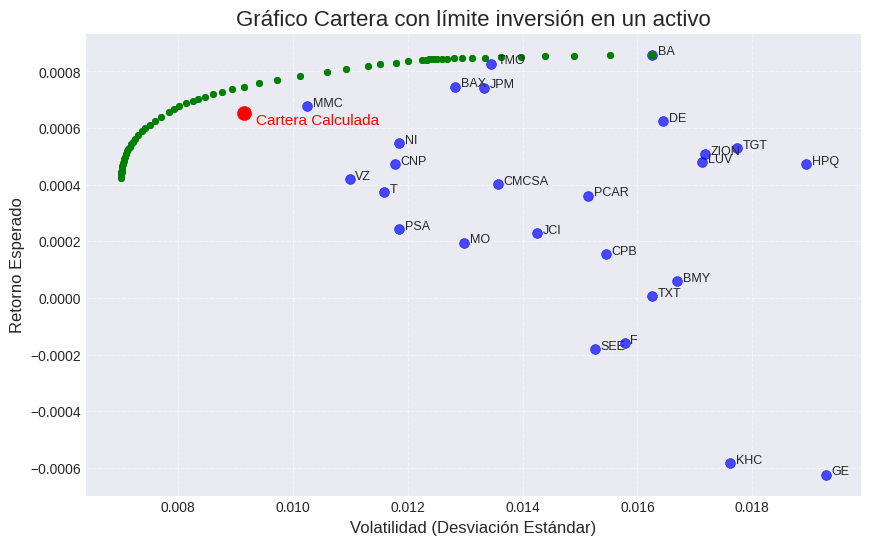

In [155]:
# Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, label='Activos', alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00002  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')#,  alpha=0.3)   


plt.scatter(np.sqrt(cp.quad_form(pesos, matriz_cov).value), resultado, color='red', s=100, marker='o', label='Cartera Calculada')
plt.text(np.sqrt(cp.quad_form(pesos, matriz_cov).value) + 2*desplazamiento_x, resultado - 2*desplazamiento_y, 'Cartera Calculada', fontsize=11, color='red')

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')

# Añadiendo títulos y etiquetas
plt.title('Gráfico Cartera con límite inversión en un activo', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

## Ejercicio 8: Carteras con restricciones en número mínimo de activos y de rentabilidad esperada

Se busca encontrar una cartera que no solo supere un determinado nivel de rentabilidad, sino que también incluya un número mínimo de activos, promoviendo así la diversificación.

In [173]:
# Definimos el retorno mínimo deseado como un factor del retorno máximo
factor = 0.8
minimum_return = factor * retornos_esperados.max()


In [174]:
#Variables de decisión
pesos = cp.Variable(num_act)

riesgo = cp.quad_form(pesos, matriz_cov)

In [175]:
# Constraints

constraint_sum_of_weights = cp.sum(pesos) == 1
constraint_expected_return = retornos_esperados.T @ pesos >= minimum_return
constraint_no_short_selling = pesos >= 0

Ahora definimos las restricciones que aseguran tener un número mínimo de activos:

**Inclusión de al menos 5 activos**: 

  - Se utilizan variables binarias para la selección (`selection`).

  - Estas variables valen 1 si el activo forma parte de la cartera o 0 en caso contrario
  
  - `constraint_minimum_assets = cp.sum(selection) >= 5` asegura que al menos 5 activos sean incluidos.

**Vinculación de variables de selección con los pesos**:

- `constraint_link_selection_weights = weights <= selection` crea una relación entre cada peso y su variable de selección.
   
    - Si un activo no está seleccionado (`selection[i] = 0`), su peso (`pesos[i]`) se establece en cero. Esto impide que activos no seleccionados influyan en la cartera.
  
    - Si un activo está seleccionado (`selection[i] = 1`), su peso puede ser positivo, permitiendo su inclusión en la cartera.
  
    - Este método asegura que solo los activos seleccionados tengan un impacto en la composición de la cartera.

In [176]:
min_act = 12
selection = cp.Variable(num_act, boolean=True)
constraint_minimum_assets = cp.sum(selection) >= min_act

# Creamos una relacion entre cada peso y su variable de selección
constraint_link_selection_weights = pesos <= selection
small_positive_value = 1e-4
constraint_weight_significance = pesos >= small_positive_value * selection

<font color="red">CHRIS: OJO A USAR ECOS_BB, ME DICE QUE NO TIENE SOLUCION</font>

<font color="red">CHRIS: OJO! ESTE CODIGO NO FUNCIONA. SI FIJAS EL min_act=12 SE LO COME</font>

In [177]:
# Problem
problem = cp.Problem(cp.Minimize(riesgo), 
                     [constraint_sum_of_weights,
                      constraint_expected_return,
                      constraint_no_short_selling,
                      constraint_minimum_assets,
                      constraint_link_selection_weights,
                      constraint_weight_significance])

# Solve the problem
resultado = problem.solve(solver=cp.GUROBI) #Hay que indicar el solver ya que hay variables binarias

#resultado = problem.solve(solver=cp.ECOS_BB) #Hay que indicar el solver ya que hay variables binarias


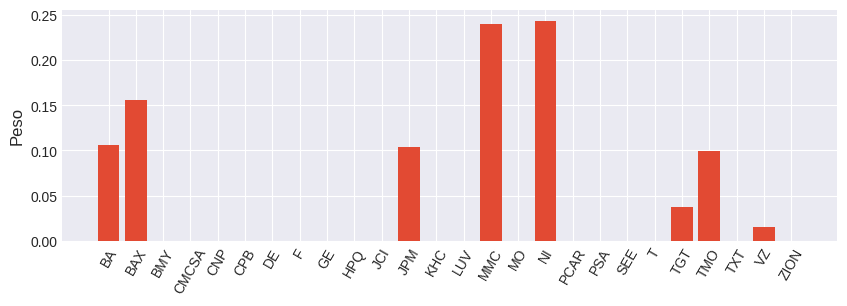

In [180]:
plt.figure(figsize=(10, 3))
plt.bar(range(num_act), pesos.value)
plt.xticks(range(num_act), assets, rotation=60)
plt.ylabel("Peso")
plt.show()

In [178]:
pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value])

activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x > 0]

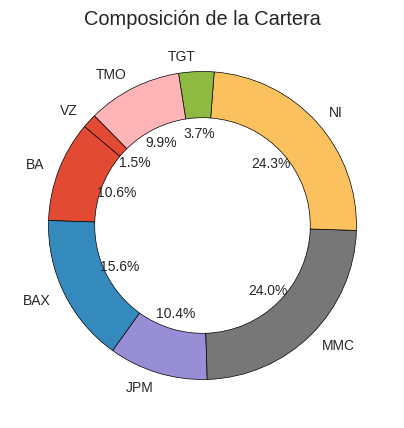

In [179]:
# Crear el gráfico de donut
plt.figure(figsize=(5, 5))

plt.pie(pesos_filtrados, labels=activos_filtrados, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.3, 'edgecolor': 'black'})

# Añadir título
plt.title('Composición de la Cartera')

# Mostrar el gráfico
plt.show()

In [171]:
# Calculo la rentabilidad de la cartera
ret = (retornos_esperados.T @ pesos).value

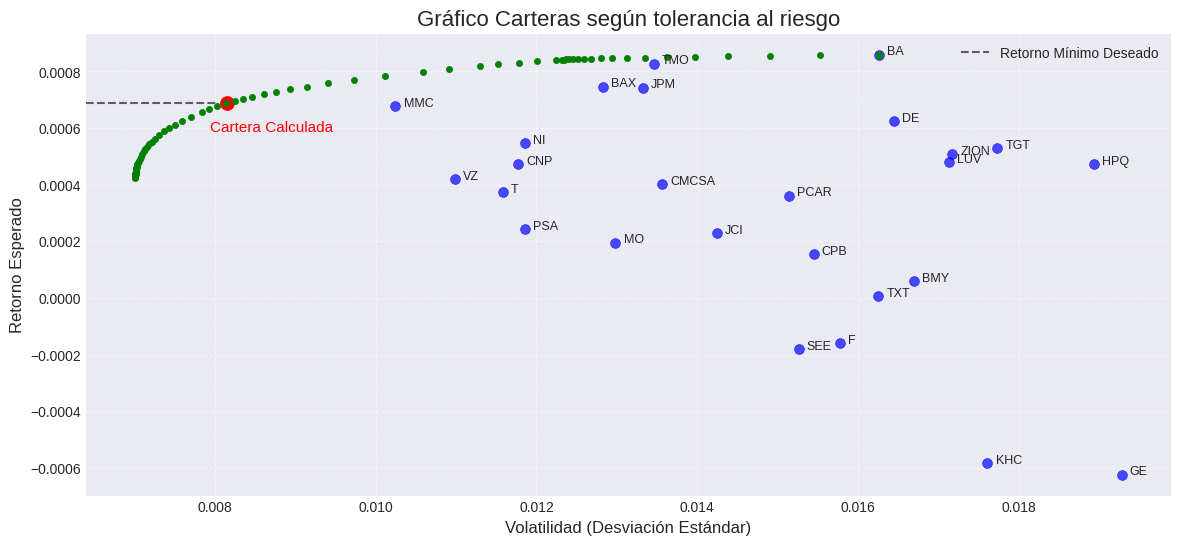

In [172]:
#Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(14, 6))

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.0001  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i], asset, fontsize=9)

#plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')#,  alpha=0.3)   
    
plt.axhline(xmin = 0, xmax = 0.12, y=minimum_return, color='black', linestyle='--', label='Retorno Mínimo Deseado', alpha=0.6)


plt.scatter(np.sqrt(resultado), ret, color='red', s=100, marker='o')
plt.text(np.sqrt(resultado) - 2*desplazamiento_x, ret - desplazamiento_y, 'Cartera Calculada', fontsize=11, color='red')

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')

# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras según tolerancia al riesgo', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

---

### 7. Cartera de máximo ratio de sharpe



El **ratio de sharpe**  ss una medida para calcular el rendimiento ajustado al riesgo de una inversión, se define como:

- la diferencia entre el retorno de una inversión y la tasa libre de riesgo
- dividido por la desviación estándar de la inversión (es decir, el riesgo). 


Matemáticamente, se expresa como:

$\qquad \qquad \text{Ratio de Sharpe} = \Large \frac{R_p - R_f}{\sigma_p}$

Donde:
- $ R_p $ es el retorno esperado de la cartera.
- $ R_f $ es la tasa de retorno libre de riesgo.
- $ \sigma_p $ es la desviación estándar de los retornos de la cartera, que representa el riesgo.

## Por qué el Ratio de Sharpe no es una función convexa

La naturaleza no convexa del *ratio de Sharpe* se debe a las características de su formulación matemática:

- **Forma de la Función**: El ratio de Sharpe  es una fracción con el riesgo (una raíz cuadrada) en el denominador.

- **Desviación Estándar (Riesgo)**: La desviación estándar, $\sigma_p$, es una función cóncava porque es la raíz cuadrada de la varianza (que es una suma de cuadrados).
En matemáticas, la raíz cuadrada de una función cuadrática no es convexa.

- **División por una Función Cóncava**: Dividir una función lineal (el exceso de retorno) por una función cóncava (la desviación estándar) resulta en una función que no es necesariamente convexa. Las operaciones que involucran la división por funciones cóncavas no preservan la convexidad.

- **Violación de la Desigualdad de Jensen**: Una propiedad clave de las funciones convexas es que deben cumplir la desigualdad de Jensen. El ratio de Sharpe no cumple con esta desigualdad debido a su denominador cóncavo.

En resumen, la combinación de una función lineal en el numerador y una función cóncava en el denominador es lo que hace que el ratio de Sharpe no sea convexo. Esto tiene implicaciones importantes en optimización, ya que los métodos estándar para optimizar funciones convexas no pueden aplicarse directamente para maximizar el ratio de Sharpe.


## Transformaciones en la Aplicación de Charnes y Cooper [Charnes](https://onlinelibrary.wiley.com/doi/10.1002/nav.3800090303)

- **Introducción de Nueva Variable**:
  - Se introduce una nueva variable $ y $, definida como $ y = \frac{1}{\sigma_p} $, donde $ \sigma_p $ es la desviación estándar de los retornos de la cartera.

- **Transformación de Variables de Cartera**:
  - Las variables de ponderación de la cartera $ w_i $ se transforman en nuevas variables $ z_i $.
  - La transformación es $ z_i = w_i * y $.

- **Reformulación de la Función Objetivo**:
  - El objetivo de maximizar $ \frac{R_p - R_f}{\sigma_p} $ se transforma en maximizar $ (R_p - R_f) * y $.
  - La función objetivo se convierte en una función lineal de $ z $ y $ y $.

- **Reformulación de las Restricciones de Cartera**:
  - Las restricciones originales, como la suma de los pesos igual a 1, se reformulan para las nuevas variables.
  - La nueva restricción es $ \sum z_i = y $.

- **Resolución del Problema Transformado**:
  - El problema transformado, ahora lineal, se resuelve utilizando métodos de optimización lineal.

- **Retransformación a Variables Originales**:
  - Después de resolver el problema, se retransforman las variables $ z $ y $ y $ a las variables originales $ x $ para obtener la solución del problema original.


In [40]:
ret_rf = 0.0002

# Variable de decisión (pesos del portafolio)
pesos = cp.Variable(num_act)
y = cp.Variable(nonneg=True)

In [42]:
# Riesgo (desviación estándar) del portafolio
riesgo = cp.quad_form(pesos, matriz_cov)

# Rentabilidad del portafolio
ret = retornos_esperados.T @ pesos

#Restricciones
constraints = [pesos >= 0,  # No shorting
               cp.sum(pesos) == y, # Fully invested
               #ret - ret_rf * y ==1
               ]

objective = cp.Minimize(riesgo) # Maximizar el ratio de Sharpe

# Problema de optimización
problema = cp.Problem(objective, constraints)         # Sin ventas en corto (pesos no negativos)

# Resolver el problema
problema.solve(solver=cp.MOSEK)

# Las ponderaciones óptimas para maximizar el Ratio de Sharpe
pesos_df = pd.DataFrame(pesos.value/y.value, index=assets, columns=['Ponderaciones'])

print(pesos_df)

       Ponderaciones
BA           2.8310%
BAX          3.9831%
BMY          3.8367%
CMCSA        3.6685%
CNP          4.8454%
CPB          4.6984%
DE           3.2592%
F            2.9396%
GE           3.2909%
HPQ          3.0159%
JCI          3.2811%
JPM          2.9865%
KHC          3.4650%
LUV          3.2365%
MMC          4.0132%
MO           4.8059%
NI           6.0949%
PCAR         3.1451%
PSA          6.5060%
SEE          3.2829%
T            4.5677%
TGT          4.2767%
TMO          3.1426%
TXT          3.0846%
VZ           4.6255%
ZION         3.1171%


---

Ahora volvemos al ejemplo inicial donde todos los activos tienen ganancias.

¿Podremos ganar más usando posiciones cortas en este caso?

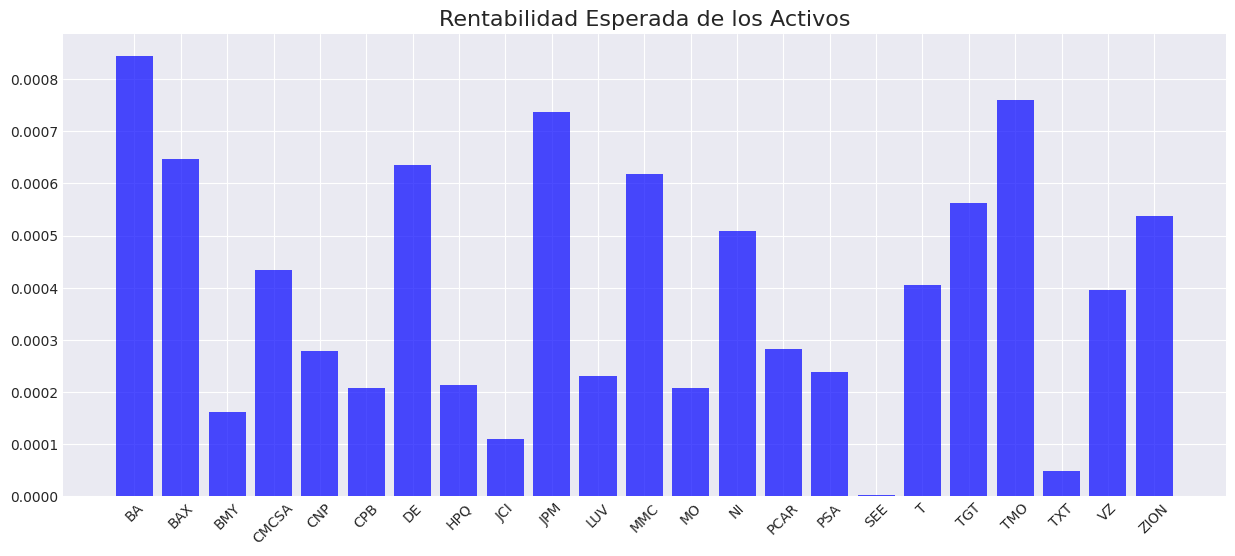

In [175]:
plt.figure(figsize=(15, 6))

plt.bar(range(len(retornos_esperados)), retornos_esperados, color='blue', alpha=0.7)

# Añadiendo los nombres de los activos como etiquetas en el eje x
plt.xticks(range(len(assets)), assets, rotation=45)

plt.title('Rentabilidad Esperada de los Activos', fontsize=16);





In [176]:
pesos = cp.Variable(num_act)

# Restricciones
constraints = [
    cp.sum(pesos) == 1,                 # La suma de los pesos debe ser igual a 1
    cp.sum(cp.abs(pesos)) <= 1.3        # El endeudamiento total no debe superar el 30%
]

# Función objetivo (maximizar el retorno esperado)
retorno_esperado = retornos_esperados @ pesos
objetivo = cp.Maximize(retorno_esperado)

# Definir y resolver el problema
problema = cp.Problem(objetivo, constraints)
resultado = problema.solve(solver=cp.ECOS)

riesgo = cp.quad_form(pesos, matriz_cov)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


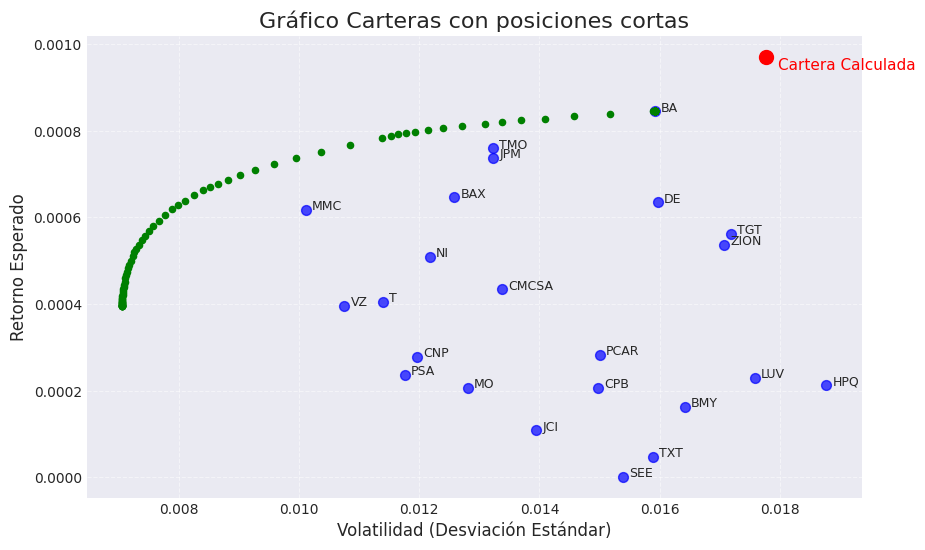

In [177]:
#Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)



plt.scatter(np.sqrt(riesgo.value), resultado, color='red', s=100, marker='o')
plt.text(np.sqrt(riesgo.value) + 2*desplazamiento_x, resultado - desplazamiento_y, 'Cartera Calculada', fontsize=11, color='red')

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')


# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras con posiciones cortas', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

---

In [5]:
cp.installed_solvers()

['CLARABEL', 'ECOS', 'ECOS_BB', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']